Are you confident with your ability to spot fake news? Do you know that seven in ten Americans overestimate their ability in identifying false headlines? Well, one should even wonder whether what I just claimed is verifiable and truthful or not. Hence, instead of spending hours researching and verifying from one source to another, why we dont't leave this task to our trusworthy computer. With that being said, in this blog post, let us explore the art of assessing and detecting **fake** news through machine learning and more specifically with ``Tensorflow``.

### §1. Dataset
#### A. Source
We will use data from the following article
> Ahmed H, Traore I, Saad S. (2017) “Detection of Online Fake News Using N-Gram Analysis and Machine Learning Techniques. In: Traore I., Woungang I., Awad A. (eds) Intelligent, Secure, and Dependable Systems in Distributed and Cloud Environments. ISDDC 2017. Lecture Notes in Computer Science, vol 10618. Springer, Cham (pp. 127-138).

which is accessed through [Kaggle](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset). Professor Chodrow already did some cleaning and performed a train-test split for us, so we can rest assured and get into our main task of the day. Before that, let's access and take a look at the data.

In [1]:
import pandas as pd

train_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_train.csv?raw=true"
news = pd.read_csv(train_url)
news

,Unnamed: 0,title,text,fake
0,17366,Merkel: Strong result for Austria's FPO 'big c...,German Chancellor Angela Merkel said on Monday...,0
1,5634,Trump says Pence will lead voter fraud panel,"WEST PALM BEACH, Fla.President Donald Trump sa...",0
2,17487,JUST IN: SUSPECTED LEAKER and “Close Confidant...,"On December 5, 2017, Circa s Sara Carter warne...",1
3,12217,Thyssenkrupp has offered help to Argentina ove...,"Germany s Thyssenkrupp, has offered assistance...",0
4,5535,Trump say appeals court decision on travel ban...,President Donald Trump on Thursday called the ...,0
...,...,...,...,...
22444,10709,ALARMING: NSA Refuses to Release Clinton-Lynch...,If Clinton and Lynch just talked about grandki...,1
22445,8731,Can Pence's vow not to sling mud survive a Tru...,"() - In 1990, during a close and bitter congre...",0
22446,4733,Watch Trump Campaign Try To Spin Their Way Ou...,A new ad by the Hillary Clinton SuperPac Prior...,1
22447,3993,"Trump celebrates first 100 days as president, ...","HARRISBURG, Pa.U.S. President Donald Trump hit...",0


#### A. Construct Tensorflow Dataset
As there are many unncessary filler words such as "but", "or", "and", etc, in these articles which do not make a significant contribution in identifying fake news, let's first define a function to remove them.

**Note**: These words are also known as *stopwords*.

In [2]:
from nltk.corpus import stopwords
import tensorflow as tf
stop = stopwords.words('english')

def make_dataset(df):
    """
    FUNCTION
    --------
    1. Remove stopwords from two columns "text" and "title" of a panda dataframe
    2. Create a Tensorflow dataset with two input (text, tile) and one output (fake)
    INPUT & OUTPUT
    --------------
    input -- df: a panda dataframe which contains the two columns as mentioned
    output -- data: the newly created tensorflow dataset
    """
    # use lambda function and list comprehension to remove stopwords
    df['title'] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

    # construct the tensorflow data set
    # the first dictionary indicates the predictor data components
    # the second one specifies the target data components
    data = tf.data.Dataset.from_tensor_slices(
      ({
          "title" : df[["title"]],
          "text"  : df[["text"]]
      },
       {
           "fake" : df[["fake"]]
        })
      )

    # batch the dataset so that the model trains on chunks of data
    # => faster training time but may reduce accuracy
    data.batch(100)
    return data

Let's see if our function performs as we intend it to be.

In [3]:
data = make_dataset(news)
data

<TensorSliceDataset shapes: ({title: (1,), text: (1,)}, {fake: (1,)}), types: ({title: tf.string, text: tf.string}, {fake: tf.int64})>

We seem to successfully construct a Tensorflow dataset, but the output may not look very friendly here. It's a good idea to take a glance at the contents of our newly created dataset.

In [4]:
for title, text in data.take(1):
    print(title, text)

{'title': <tf.Tensor: shape=(1,), dtype=string, numpy=
array([b"Merkel: Strong result Austria's FPO 'big challenge' parties"],
      dtype=object)>, 'text': <tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'German Chancellor Angela Merkel said Monday strong showing Austria anti-immigrant Freedom Party (FPO) Sunday election big challenge parties. Speaking news conference Berlin, Merkel added hoping close cooperation Austria conservative election winner Sebastian Kurz European level.'],
      dtype=object)>} {'fake': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>}


That looks like a great piece of news there, and yes it's valid information.
#### B. Validation Data
Now, we will split our dataset into two parts; 20% of the data is for **validation**, and the rest of it would be used for **training**. The main reason we perform this splitting is because we want to make sure that our model is not get too "comfortable" with predicting data that it only gets trained with too well, i.e., *overfitting*. Thus, in order to reduce such risks, it's crucial to increase the model's diversity as well as its flexibility with handling new information. Besides, we also will batch our data into chunks of size 80, which would significantly decrease the training time later.

In [5]:
# shuffle data
data = data.shuffle(buffer_size = len(data))

# split the data
train_size = int(0.8*len(data))
train = data.take(train_size).batch(80)
val   = data.skip(train_size).batch(80)
len(train), len(val)

(225, 57)

### §2. Create Models
In this section, we will create three models with an attempt to answer the following question
> When detecting fake news, is it most effective to focus only on the title of the article, the full text of the article, or both?

Thus, each model we build will correspond to each scenario in the question.
#### A. Data Preprocessing
There are essentially two steps that we need to follow to prepare the data for the learning process.
1. Standardization: clean undesirable texts through removing punctuations and replacing capitals with lowercases.
2. Vectorization: encoding texts as vector of numbers as computers only know how to deal with numbers.

Before getting into this, there is an important aspect that we need to investigate. For our model to learn effectively, we need to consider how many words and the length of each sequence we should feed to our model for training. In fact, I get this brilliant idea from [David](https://davidyu8.github.io/HW3/) in his blog post in which he talks about estimating these values so that we can have a better look at the bigger picture of the gain/lost from a certain value.


In [6]:
# the code below is from David's blog post mentioned above

# find the total number of words in text
len_text = set()
news['text'].str.lower().str.split().apply(len_text.update)
# find the total number of words in title
len_title = set()
news['title'].str.lower().str.split().apply(len_title.update)

len(len_text), len(len_title)

(251617, 31023)

We can certainly see that there are a huge number of words in the `text` columns, and it's significantly less for the `title` column which is as expected. How about the number of words in the longest/shortest articles?

In [7]:
max_text_len = news['text'].str.lower().str.len().max()
max_title_len = news['title'].str.lower().str.len().max()
min_text_len = news['text'].str.lower().str.len().min()
min_title_len = news['title'].str.lower().str.len().min()
print("Longest:", (max_title_len, max_text_len))
print("Shortest:", (min_title_len, min_text_len))

Longest: (261, 40034)
Shortest: (8, 0)


From these numbers, it's reasonable to choose a vocabulary size of 5000, which is about 1/8 of the number of words in the text of the longest article, but remember that these words are all distinct, and there will be surely some patterns emerged with certain number of words. Our job here is best predict such a number.

Now, it's time for us to jump in the actual preprocessing time. First, we will standardize the text with a function.

In [8]:
import re
import string

def standardization(input_data):
    """
    Take in a Tensorflow dataset to remove punctuation
    and replace capital letters with the corresponding lowercase
    """
    lowercase = tf.strings.lower(input_data) 
    no_punctuation = tf.strings.regex_replace(lowercase, '[%s]' % re.escape(string.punctuation),'')
    return no_punctuation 

For the next step, we will vectorize our texts, which is in essence, encode them as vectors of numbers in which each of these numbers represents its corresponding text's frequency rank.

In [9]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

def vectorize_layer(train, feature, vocab_size, sequence_length):
    """
    Function:
    Create vectorize layer to encode and adapt it for the learning process.

    Input:
    train: training data
    feature: name of column
    vocab_size: the number of vocabulary for training
    sequence_length: length of each sequence for training

    Output: the result vectorize layer
    """
    # create vectorize layers to encode and prepare for learning
    vectorize_layer = TextVectorization(
        standardize=standardization,
        max_tokens=vocab_size,
        output_mode='int',
        output_sequence_length=sequence_length)
        
    # adapt the layer 
    vectorize_layer.adapt(train.map(lambda x, y: x[feature]))
    return vectorize_layer

We can now create two different layers for `title` and `text`.

In [10]:
vectorize_title = vectorize_layer(train, 'title', 5000, 300)
vectorize_text = vectorize_layer(train, 'text', 5000, 1000)

Next, we need to specify the details of the two inputs for our model. As both `title` and `text` only contain one piece of information, their shapes are thus (1,).

In [11]:
from tensorflow import keras

title_input = keras.Input(
    shape = (1,),
    name = "title",
    dtype = "string"
)
text_input = keras.Input(
    shape = (1,),
    name = "text",
    dtype = "string"
)

Now, it's time for us to construct the first model.
#### B. First Model -- Title
For the first trial, we will test how our model performs with title. Basically, it would utilize the vectorize layer, ``vectorize_title``, to enconde the inputs and learn the pattern through a number of layers. An input would first be fed into a layer where it gets transformed through a series of complicated mathematical functions/computations, and the output would then be used for the next layer. This process gets repeated until we run out of layers. 

Let's define the pipelines for the title feature


In [12]:
from tensorflow.keras import layers

# shared embedding layer
shared_embedding = layers.Embedding(5000, 20, name='embedding')
# the actual layers for title feature
title_features = vectorize_title(title_input)
title_features = shared_embedding(title_features)
title_features = layers.GlobalAveragePooling1D()(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.Dense(32, activation='relu')(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.Dense(32, activation='relu')(title_features)
title_output = layers.Dense(2, name='fake')(title_features)

Notice here that we define a ``share_embedding`` as this variable (embedding) can be used later on for the ``text`` model. Also, we can observe that there are quite a few layers added to the model. Especially with the ``Dropout`` layer, it's particularly used to prevent overfitting as we emphasized earlier. Other layers are filled with complex mathematical functions to which are critical for the model to learn and process the input. Finally, we can build the model.

In [13]:
title_model = keras.Model(
    inputs = title_input,
    outputs = title_output
)

Let's take a look at the model's summary.

In [14]:
title_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
title (InputLayer)           [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 300)               0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 20)           100000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 20)                0         
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                672       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0     

We have over 100,000 parameters -- which is a pretty rational number for this type of task. As we're here, let's observe how the layers defined above are organized and structured.

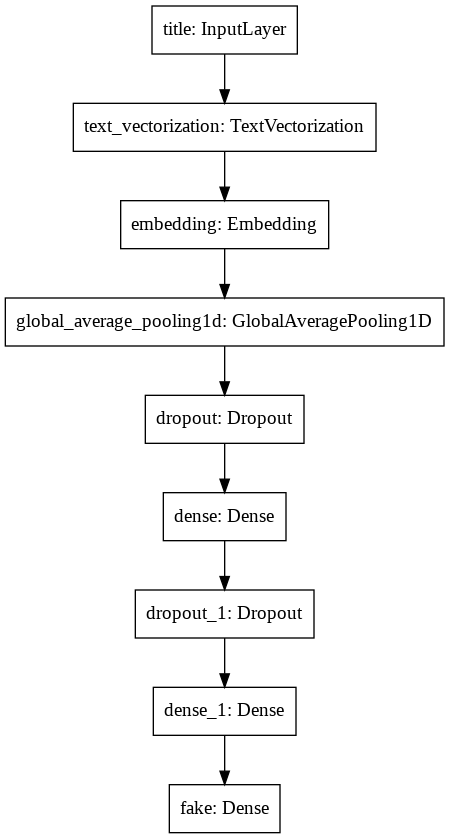

In [15]:
keras.utils.plot_model(title_model)

And we're ready to compile the model now.

In [16]:
from tensorflow.keras import losses

title_model.compile(optimizer = 'adam',
                    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
                    metrics = ['accuracy']
)

What comes after compiling the model? Without a doubt, it's training. For this one, let's set the number of *epochs* to be 10.

In [17]:
title_history = title_model.fit(train,
                                validation_data = val,
                                epochs = 10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:591: UserWarning: Input dict contained keys ['text'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


225/225 [==============================] - 3s 9ms/step - loss: 0.6781 - accuracy: 0.5822 - val_loss: 0.5670 - val_accuracy: 0.9528
Epoch 2/10
225/225 [==============================] - 2s 8ms/step - loss: 0.2190 - accuracy: 0.9429 - val_loss: 0.0765 - val_accuracy: 0.9766
Epoch 3/10
225/225 [==============================] - 2s 8ms/step - loss: 0.0704 - accuracy: 0.9767 - val_loss: 0.0570 - val_accuracy: 0.9817
Epoch 4/10
225/225 [==============================] - 2s 8ms/step - loss: 0.0509 - accuracy: 0.9825 - val_loss: 0.0622 - val_accuracy: 0.9780
Epoch 5/10
225/225 [==============================] - 2s 8ms/step - loss: 0.0427 - accuracy: 0.9862 - val_loss: 0.0263 - val_accuracy: 0.9913
Epoch 6/10
225/225 [==============================] - 2s 8ms/step - loss: 0.0385 - accuracy: 0.9870 - val_loss: 0.0293 - val_accuracy: 0.9911
Epoch 7/10
225/225 [==============================] - 2s 8ms/step - loss: 0.0309 - accuracy: 0.9901 - val_loss: 0.0166 - val_accuracy: 0.9951
Epoch 8/10
225/22

Hurray! Our model achieved such an impressive result, over 99% validation accuracy. Well, let's actually visualize how it performs over time.

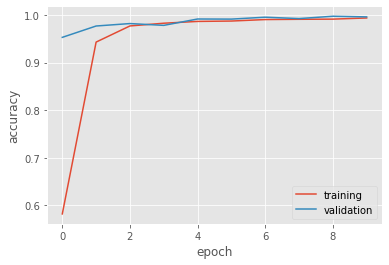

In [18]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def perf_plot(feature):
    """
    Plot the performance of a model where the accuracy is plotted
    against epochs for training and validation datasets
    """
    plt.plot(feature.history['accuracy'], label='training')
    plt.plot(feature.history['val_accuracy'], label='validation')
    plt.gca().set(xlabel='epoch', ylabel='accuracy')
    plt.legend()

perf_plot(title_history)

As seen from the figure, the performance jumps noticeably from the first epoch, and it steadily approaches 1 after that. Observe that both the training and validation curves are quite similar to each other after the second epochs, so overfitting is not an isse that we have to worry about at all.

#### C. Second Model -- Text
Recall that we already defined an embedding layer from the first model, so we can just reuse it. We proceed similarly to the first model.

In [19]:
text_features = vectorize_text(text_input)
text_features = shared_embedding(text_features)
text_features = layers.GlobalAveragePooling1D()(text_features)
text_features = layers.Dropout(0.2)(text_features)
text_features = layers.Dense(32, activation='relu')(text_features)
text_features = layers.Dropout(0.2)(text_features)
text_features = layers.Dense(32, activation='relu')(text_features)
text_output = layers.Dense(2, name='fake')(text_features)

As before, we can build the model and inspect the model summary.

In [20]:
text_model = keras.Model(
    inputs = text_input,
    outputs = text_output
)
text_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 1000)              0         
_________________________________________________________________
embedding (Embedding)        multiple                  100000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 20)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                672       
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0   

Likewise, let's compile and train the model.

In [21]:
text_model.compile(optimizer = 'adam',
                   loss = losses.SparseCategoricalCrossentropy(from_logits = True),
                   metrics = ['accuracy']
)

Time for some fitting!

In [22]:
text_history = text_model.fit(train,
                              validation_data = val,
                              epochs = 10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:591: UserWarning: Input dict contained keys ['title'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


225/225 [==============================] - 6s 22ms/step - loss: 0.5594 - accuracy: 0.7160 - val_loss: 0.2190 - val_accuracy: 0.9517
Epoch 2/10
225/225 [==============================] - 5s 22ms/step - loss: 0.1700 - accuracy: 0.9419 - val_loss: 0.1055 - val_accuracy: 0.9708
Epoch 3/10
225/225 [==============================] - 5s 22ms/step - loss: 0.1059 - accuracy: 0.9683 - val_loss: 0.0712 - val_accuracy: 0.9815
Epoch 4/10
225/225 [==============================] - 5s 22ms/step - loss: 0.0783 - accuracy: 0.9760 - val_loss: 0.0567 - val_accuracy: 0.9831
Epoch 5/10
225/225 [==============================] - 5s 22ms/step - loss: 0.0575 - accuracy: 0.9827 - val_loss: 0.0363 - val_accuracy: 0.9895
Epoch 6/10
225/225 [==============================] - 5s 22ms/step - loss: 0.0444 - accuracy: 0.9874 - val_loss: 0.0268 - val_accuracy: 0.9942
Epoch 7/10
225/225 [==============================] - 5s 22ms/step - loss: 0.0375 - accuracy: 0.9898 - val_loss: 0.0209 - val_accuracy: 0.9951
Epoch 8/10

Remarkably, we also obtained over 99% for training and validation accuracy for this model. Let's see how the model's performance through each epoch.

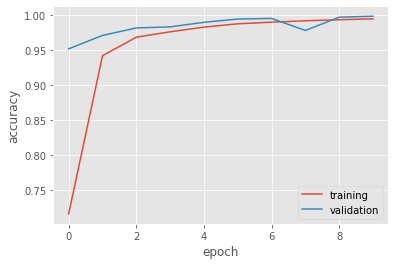

In [23]:
perf_plot(text_history)

There's apparently a very small gap between the two curves, but as the number of epochs increases, we can see that they both converge to the same value. Thus, overfitting is negligible here.

#### D. Third Model -- Title & Text
Lastly, to train a model on both `title` and `text`, we need to concatenate the two features that we defined earlier.

In [24]:
main = layers.concatenate([title_features, text_features], axis=1)
main = layers.Dense(32, activation='relu')(main)
main_output = layers.Dense(2, name='fake')(main)

We define the model as usual.

In [25]:
model = keras.Model(
    inputs = [title_input, text_input],
    outputs = main_output
)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
text (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 300)          0           title[0][0]                      
__________________________________________________________________________________________________
text_vectorization_1 (TextVecto (None, 1000)         0           text[0][0]                       
____________________________________________________________________________________________

The graph is quite interesting to observe as there are two inputs/paths in the model now. Let's take a look.

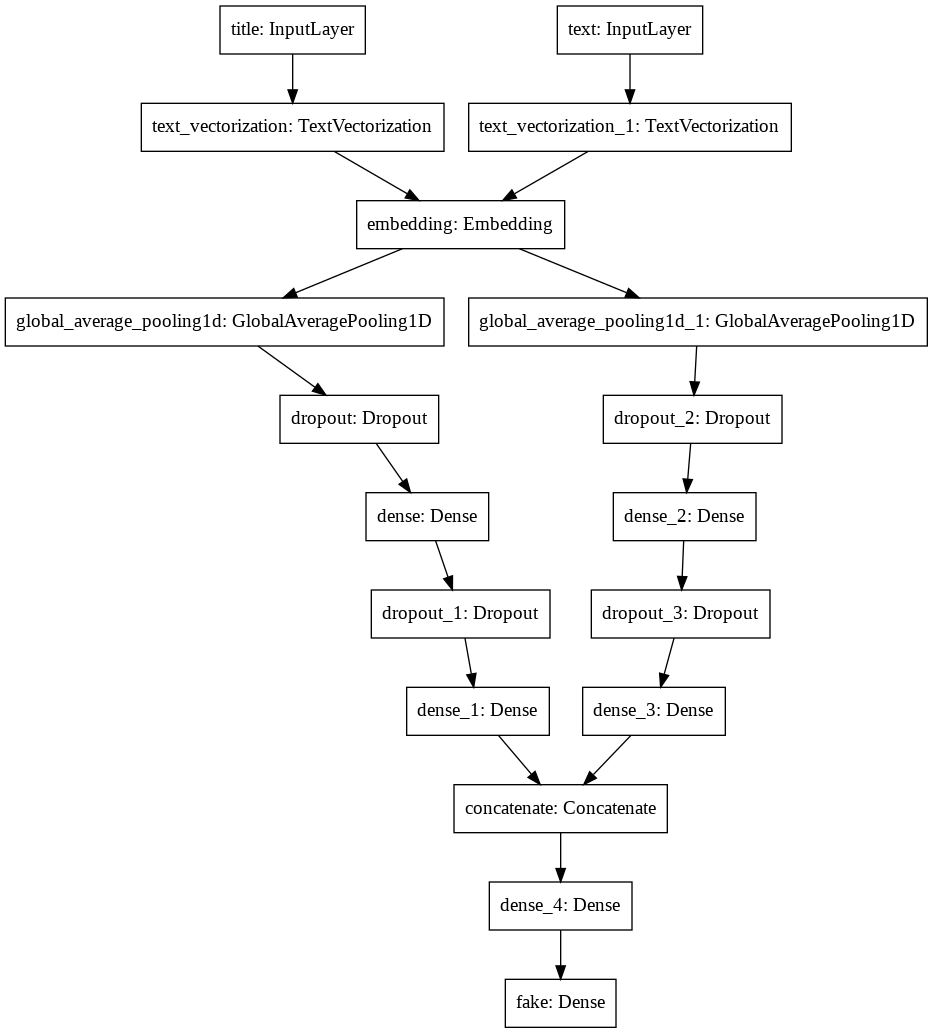

In [26]:
keras.utils.plot_model(model)

It feels like a routine now, but let's compile and fit the model again.

In [27]:
model.compile(optimizer = 'adam',
              loss = losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy']
)

In [28]:
history = model.fit(train,
                    validation_data = val,
                    epochs = 10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


225/225 [==============================] - 8s 29ms/step - loss: 0.0554 - accuracy: 0.9852 - val_loss: 0.0032 - val_accuracy: 0.9996
Epoch 2/10
225/225 [==============================] - 7s 30ms/step - loss: 0.0052 - accuracy: 0.9983 - val_loss: 0.0016 - val_accuracy: 0.9996
Epoch 3/10
225/225 [==============================] - 6s 27ms/step - loss: 0.0032 - accuracy: 0.9991 - val_loss: 8.7991e-04 - val_accuracy: 0.9996
Epoch 4/10
225/225 [==============================] - 6s 27ms/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 1.9044e-04 - val_accuracy: 1.0000
Epoch 5/10
225/225 [==============================] - 6s 28ms/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 2.1947e-04 - val_accuracy: 1.0000
Epoch 6/10
225/225 [==============================] - 6s 28ms/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 6.7279e-04 - val_accuracy: 0.9998
Epoch 7/10
225/225 [==============================] - 6s 27ms/step - loss: 0.0016 - accuracy: 0.9993 - val_loss: 8.8581e-05 - val_accurac

And let's visualize the performance.

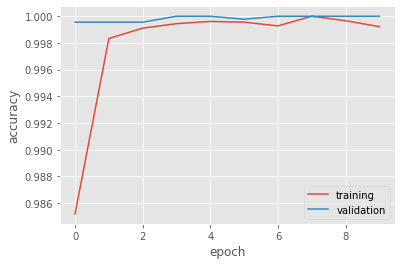

In [29]:
perf_plot(history)

Indeed, we got 100% accuracy for the last model, which is extremely impressive.

### §3. Model Evaluation & Visualization
All three of the model's performance is well over 99%, but only the last one achieves the perfect score. Thus, we can potentially pick it as our best model. Also, this turns out to be quite intuitive as it has the most information compared with the other two to train with, and thus it's just natural that it's better at predicting/detecting fake news (note that this is not always the case). For the last test, we will use a new set of data to see how it performs.

In [30]:
test_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_test.csv?raw=true"
test_df = pd.read_csv(test_url)
test_data = make_dataset(test_df)
model.evaluate(test_data)

    1/22449 [..............................] - ETA: 1:53:06 - loss: 0.0000e+00 - accuracy: 1.0000

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


22449/22449 [==============================] - 55s 2ms/step - loss: 0.0284 - accuracy: 0.9948


[0.028427032753825188, 0.9947881698608398]

Our model is indeed the ace that we're looking for. There's just no doubt about that.

Last but certainly not least, we will join in the world of dataviz again and discover what kind of patterns our model learns through visualizing its embedding.

In [31]:
weights = model.get_layer('embedding').get_weights()[0]
vocab = vectorize_text.get_vocabulary()

We first get the weights from the share embedding layer and then retrieve the vocabulary that gets encoded when we first trained the model. Note that we chose ``vectorize_text`` here because it possesses way more vocabs then ``vectorize_title``, which is ultimately more informative and useful when plotting.

What we want to do next is to perform **Principal Component Analysis (PCA)** to reduce the data into two dimensions for plotting purpose.

In [32]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
weights = pca.fit_transform(weights)

We can make an embedding dataframe that contains everything that we need now.

In [33]:
embedding_df = pd.DataFrame({
    'word' : vocab, 
    'x0'   : weights[:,0],
    'x1'   : weights[:,1]
})
embedding_df

,word,x0,x1
0,,0.028353,0.050869
1,[UNK],-0.252220,0.103668
2,said,2.659175,-0.792404
3,trump,0.101470,2.852397
4,the,2.367876,2.985684
...,...,...,...
4995,argentina,0.795248,0.124421
4996,accuses,0.290624,0.349541
4997,1995,0.415719,-0.097762
4998,unarmed,0.621208,-0.017521


We can finally plot the embedding now.

In [ ]:
import numpy as np
import plotly.express as px
from plotly.io import write_html
import plotly.io as pio
pio.templates.default = 'plotly_white'

fig = px.scatter(embedding_df,
                 x = 'x0',
                 y = 'x1',
                 size = list(np.ones(len(embedding_df))),
                 size_max = 2,
                 hover_name = 'word')
write_html(fig, 'embedding_viz.html')
fig.show()

At first glance, this looks like a big chunk of data clumped together, but there's still something that we can certainly extract from. Overall, there appears to be a lot of keywords revolved around politics around the corner of every sides. Words such as "obama", "trumps", "gop", "democrats" seem to be indicative and significant factors how whether a piece of news is fake or not. On the other hand, if we focus on the middle of the figure, there are indeed all sorts of words there which doesn't seem to follow a certain topic/theme.